# Baseball Savant Pitch Selection Algorithm - Final Report

Name(s): Connor Vucovich, Doruk Ozar, and Taylor LaMantia

Class: CSCI 349 - Intro to Data Mining  

Section: 11am - 1

Semester: Spring 2024

Instructors: Brian King, Joshua Stough

# Introduction:

In baseball, teams and organization are faced with the problem of how to utilize their pitchers in order to win as many games as possible. Most pitchers throw a variety of pitches to try and fool their opponents, but the problem becomes when to throw each pitch. Many pitchers have dramatically improved their outcomes when making slight adjustments to their pitch usage. Being able to extract the equivalent of millions of dollars of added value out of their ptichers is the goal of every baseball team. 

The goal of this project is to develop a machine learning algorithm that can classify the description (outcome) of a baseball pitch based on various features such as pitch speed, spin rate, and movement. The dataset contains information about pitches thrown by various pitchers in Major League Baseball, including the pitch type, release speed, spin rate, and movement of the pitch. By training a machine learning model on this data, we  classify the description (outcome) of a given pitch based on its characteristics such as speed, rotation, pitch type, spin rate and etc.

The results of training and testing the model are shown at the end of this notebook with recommendations provided for 3 pitchers chosen at random from the set. Any given pitcher has a vertain amount of pitches that they throw. Each of these pitchers' average statistics for each of their types of pitches are used in the model and we are able to get predictions of the results of each of their types of pitches on average to show which type they should throw in order to receive a certain result.

# Data:

We are using baseball track man data from Major League Baseball’s official data storage facility. This data contains the outcome of every single pitch thrown in the MLB this past year (2024) and the metrics of the pitch as well, such as:
* pitch type
* handedness of the pitcher
* velocity of the pitch toward home
* extension the pitcher gets off of the mound toward home upon release
* amount of spin on the ball as it is released by the pitcher
* direction of the spin on the ball as it leaves the pitchers hand
* horizontal movement on the ball as it approaches the batter in feet
* vertical movement on the ball as it approaches the batter in feet
* effective speed which takes the extension the pitcher into account and adjusts the perceived velocity that the batter would see based on this distance reduction

In [136]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve


from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier

View the raw dataset

In [100]:
path = os.path.join('..', 'data', 'savant_data__2_.csv')
# Read a CSV file into a DataFrame, using the specified path
df_pitches = pd.read_csv(path)
# Set the index of the DataFrame to the 'player_name' column to allow for easier data access by player name
df_pitches.head(10)

pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         SL  2024-04-14           86.8          -1.79           5.07   
1         CH  2024-04-14           83.3          -1.87           5.05   
2         SI  2024-04-14           96.0          -1.81           4.96   
3         CH  2024-04-14           84.8          -1.99           5.08   
4         SL  2024-04-14           85.5          -1.83           5.13   
5         SI  2024-04-14           95.8          -1.69           5.02   
6         SL  2024-04-14           86.8          -1.55           5.18   
7         CH  2024-04-14           85.6          -1.77           4.96   
8         SI  2024-04-14           93.7          -1.88           5.62   
9         SI  2024-04-14           95.3          -1.80           4.91   

     player_name  batter  pitcher     events      description  ...  fld_score  \
0  Bello, Brayan  543305   678394     single    hit_into_play  ...          3   
1  Bello, Brayan  543305   678394        NaN    called_strike  ...          3   
2  Bello, Brayan  543305   678394        NaN  swinging_strike  ...          3   
3  Bello, Brayan  543305   678394        NaN             ball  ...          3   
4  Bello, Brayan  543305   678394        NaN             ball  ...          3   
5  Bello, Brayan  621493   678394     single    hit_into_play  ...          3   
6  Bello, Brayan  621493   678394        NaN             foul  ...          3   
7  Bello, Brayan  621493   678394        NaN             foul  ...          3   
8  Berríos, José  607732   621244  field_out    hit_into_play  ...          4   
9  Bello, Brayan  621493   678394        NaN             foul  ...          3   

   post_away_score  post_home_score  post_bat_score  post_fld_score  \
0                2                3               2               3   
1                2                3               2               3   
2                2                3               2               3   
3                2                3               2               3   
4                2                3               2               3   
5                2                3               2               3   
6                2                3               2               3   
7                2                3               2               3   
8                0                4               0               4   
9                2                3               2               3   

  if_fielding_alignment of_fielding_alignment spin_axis delta_home_win_exp  \
0              Standard              Standard      50.0             -0.074   
1              Standard              Standard     246.0              0.000   
2              Standard              Standard     247.0              0.000   
3              Standard              Standard     256.0              0.000   
4              Standard              Standard      27.0             -0.027   
5              Standard              Standard     243.0             -0.041   
6              Standard              Standard      56.0              0.000   
7              Standard              Standard     251.0              0.000   
8              Standard              Standard     223.0              0.004   
9              Standard              Standard     247.0              0.000   

  delta_run_exp  
0         0.793  
1        -0.098  
2        -0.091  
3         0.056  
4         0.044  
5         0.287  
6         0.000  
7         0.000  
8        -0.065  
9        -0.053  

[10 rows x 92 columns]

The raw dataset lists all of the trackable aspects of a pitch thrown in an MLB baseball game. Our target variable is the outcome of the pitch (description column), which can be placed into four main bins: *ball*, *strike*, *field_out*, and *hit*. 

In general, an outcome of *strike* and especially *field_out* is optimal, while *ball* and especially *hit* are suboptimal for the pitcher. 

Although the raw dataset contains a large amount of pitch data, some of the data is unnecessary such as the game score, inning, and player IDs, since this information has no effect on the outcome of the pitch as it does not influence the pitch, so we will not be using this data in the training of our model.

The problem of determining the effectiveness of a given pitch is of great concern to all 30 MLB baseball teams and various pitcher development organizations. Many teams, espcially those with lower budgets who cannot afford highly sought after pitchers, try to make the most of the pitchers they can afford by getting the most out of a given pitcher's arsenal. In general, most teams try to rate pitches by either focusing solely on the movement and velocity of the pitch while disregarding the outcome. This is called a Stuff+ rating, while other organizations tend to use the outcomes of the pitch to calculate the number of runs (the most important statistic in baseball as it determines the winner of each game) attributed to each pitch. Good pitcher would have lower and even negative run scores because they are so effective at preventing the other team from scoring.  

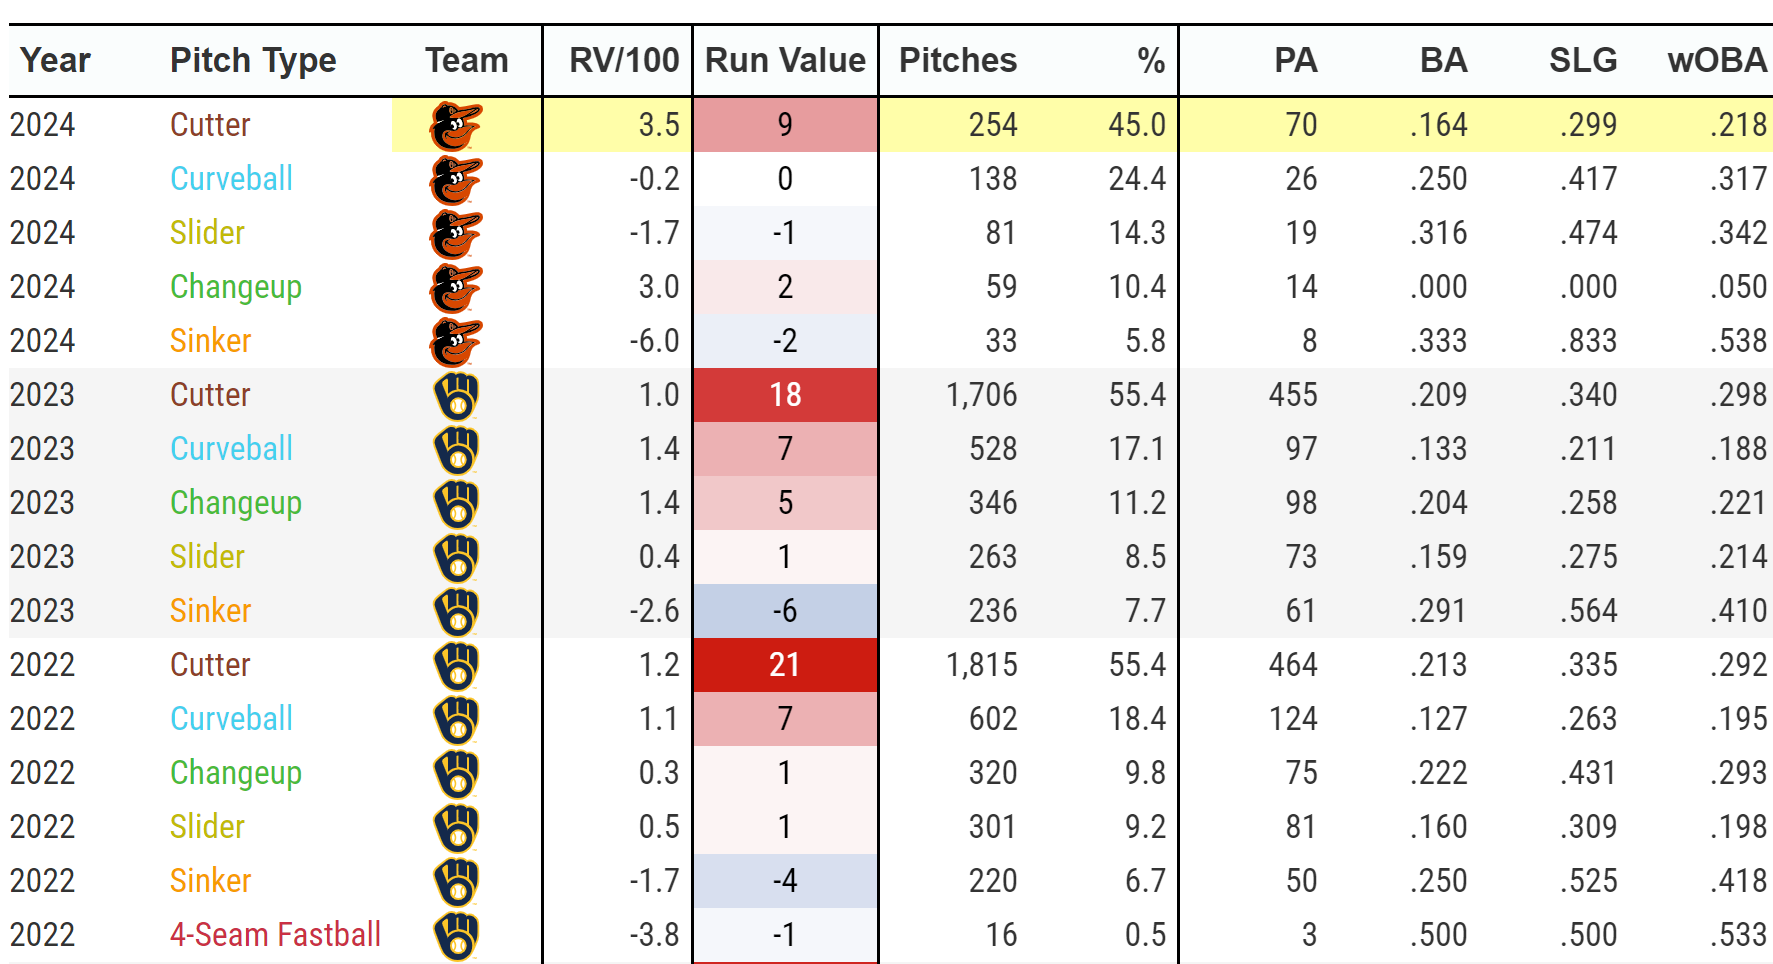

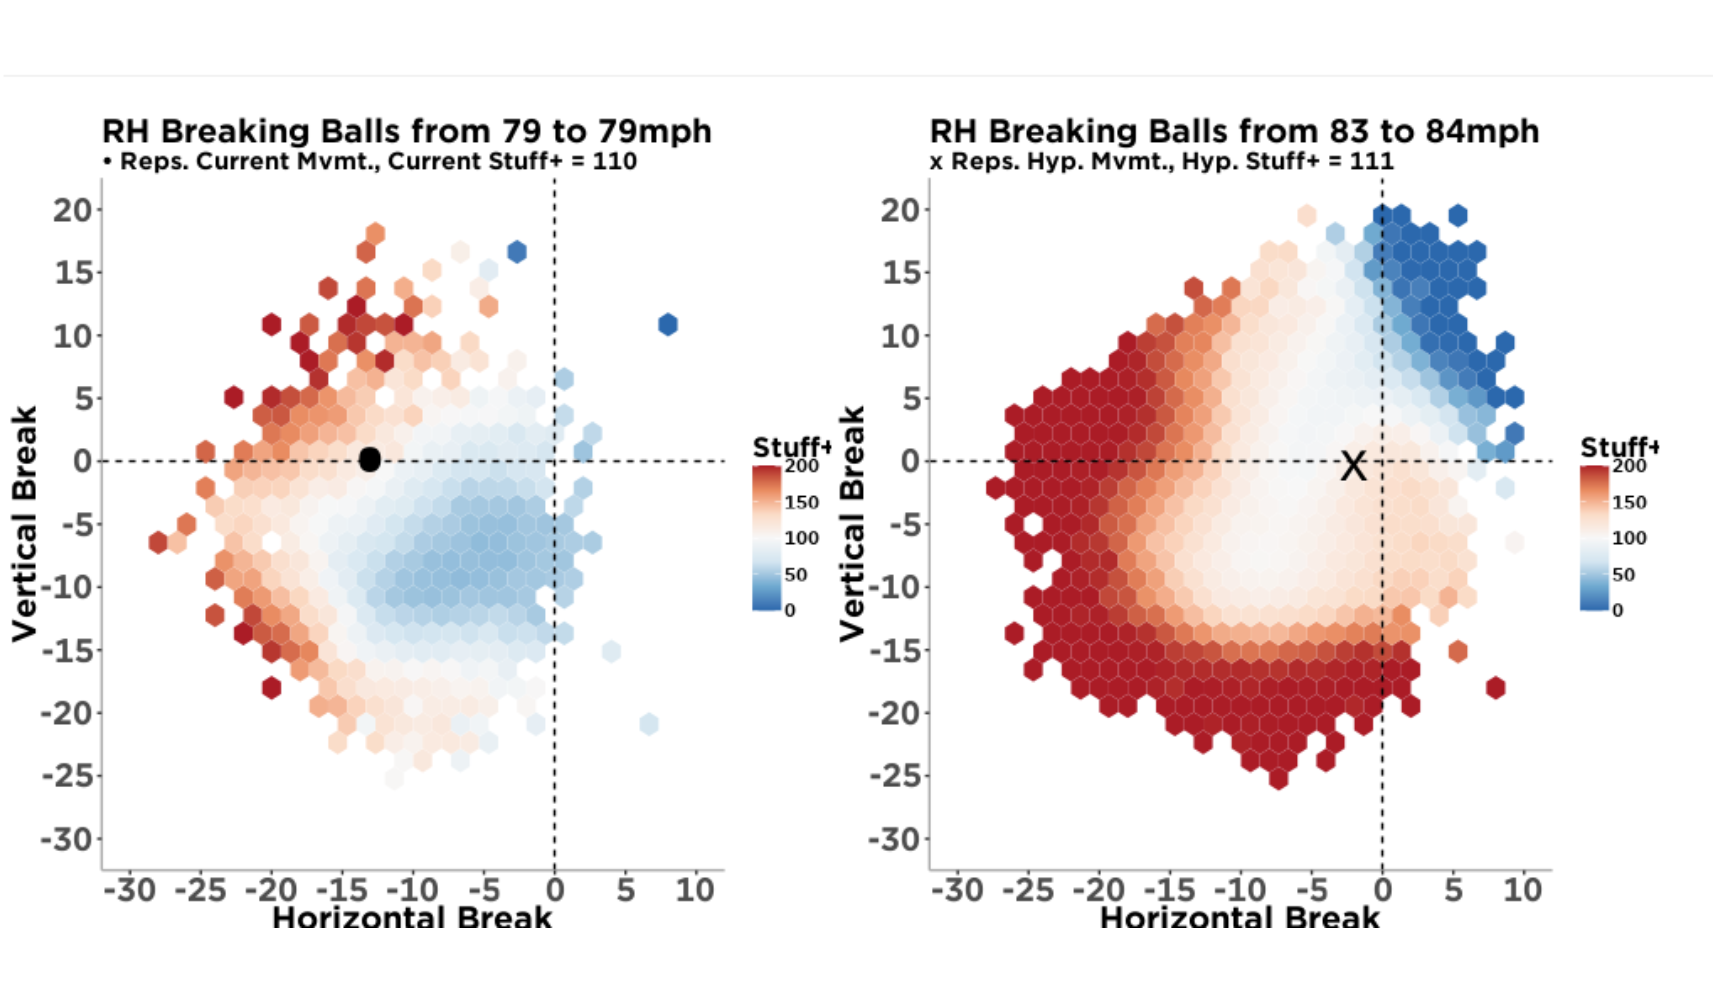

The picture above is an example of run value, while the image below is an example of stuff+ from Driveline Baseball

The pitch types are encoding as the following:
* Fastball (FF)
* Sinker (SI)
* Cutter (FC)
* Chanbgeup (CH)
* Split-finger (FS)
* Forkball (FO)
* Screwball (SC)
* Curveball (CU)
* Knuckle curve (KC)
* Slow curve (CS)
* Slider (SL)
* Sweeper (ST)
* Slurve (SV)
* Knuckleball (KN)

---

# Data Preparation: 

In [101]:
df_pitches.set_index('player_name', inplace=True)
# Create a copy of the df_pitches DataFrame to clean and manipulate the data without altering the original data
df_pitches_cleaned = df_pitches
# Replace occurrences of 'hit_into_play' in the 'description' column with NaN (not a number) values
df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)
# Fill any NaN values in the 'description' column with corresponding values from the 'events' column
df_pitches_cleaned['description'] = df_pitches_cleaned['description'].fillna(df_pitches_cleaned['events'])
# Drop the 'events' column from the DataFrame as it is no longer needed after merging its data into 'description'
df_pitches_cleaned.drop('events', axis=1, inplace=True)
# Create a new DataFrame 'df_pitches_compact' by selecting specific columns from 'df_pitches_cleaned'
df_pitches_compact = df_pitches_cleaned[['pitch_type', 'release_speed', 'effective_speed', 'spin_axis', 'release_spin_rate', 'release_extension', 'p_throws', 'pfx_x', 'pfx_z', 'description']]
# Rename the 'release_spin_rate' column to 'spin_rate' for clarity and simplicity
df_pitches_compact = df_pitches_compact.rename(columns={'release_spin_rate': 'spin_rate'})
# Rename the 'p_throws' column to 'pitcher_handedness' to more clearly describe the data it represents
df_pitches_compact = df_pitches_compact.rename(columns={'p_throws': 'pitcher_handedness'})
# Rename the 'pfx_x' column to 'horizontal_movement (ft)' to clarify that it represents the horizontal movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_x': 'horizontal_movement (ft)'})
# Rename the 'pfx_z' column to 'vertical_movement (ft)' to clarify that it represents the vertical movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_z': 'vertical_movement (ft)'})
df_pitches_compact.head(10)

C:\Users\20lam\AppData\Local\Temp\ipykernel_9940\4132977889.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)


pitch_type  release_speed  effective_speed  spin_axis  \
player_name                                                           
Bello, Brayan         SL           86.8             87.9       50.0   
Bello, Brayan         CH           83.3             84.7      246.0   
Bello, Brayan         SI           96.0             96.8      247.0   
Bello, Brayan         CH           84.8             85.6      256.0   
Bello, Brayan         SL           85.5             86.4       27.0   
Bello, Brayan         SI           95.8             97.0      243.0   
Bello, Brayan         SL           86.8             87.3       56.0   
Bello, Brayan         CH           85.6             86.4      251.0   
Berríos, José         SI           93.7             93.9      223.0   
Bello, Brayan         SI           95.3             96.4      247.0   

               spin_rate  release_extension pitcher_handedness  \
player_name                                                      
Bello, Brayan     2437.0                6.4                  R   
Bello, Brayan     1737.0                6.8                  R   
Bello, Brayan     1992.0                6.7                  R   
Bello, Brayan     1650.0                6.7                  R   
Bello, Brayan     2366.0                6.8                  R   
Bello, Brayan     2023.0                6.7                  R   
Bello, Brayan     2298.0                6.2                  R   
Bello, Brayan     1533.0                6.5                  R   
Berríos, José     1855.0                6.6                  R   
Bello, Brayan     1919.0                6.7                  R   

               horizontal_movement (ft)  vertical_movement (ft)  \
player_name                                                       
Bello, Brayan                      0.33                    0.20   
Bello, Brayan                     -1.32                    0.36   
Bello, Brayan                     -1.43                   -0.11   
Bello, Brayan                     -1.34                    0.29   
Bello, Brayan                      0.38                    0.29   
Bello, Brayan                     -1.41                    0.17   
Bello, Brayan                      0.51                    0.08   
Bello, Brayan                     -1.40                    0.00   
Berríos, José                     -1.37                    0.80   
Bello, Brayan                     -1.45                   -0.04   

                   description  
player_name                     
Bello, Brayan           single  
Bello, Brayan    called_strike  
Bello, Brayan  swinging_strike  
Bello, Brayan             ball  
Bello, Brayan             ball  
Bello, Brayan           single  
Bello, Brayan             foul  
Bello, Brayan             foul  
Berríos, José        field_out  
Bello, Brayan             foul

We worked to clean down the dataset, to cover only the variables that were attributable to each pitch and elimintated those that were unimportant such as the inning, number of outs in the innings, score, etc. Our goal was merely to isolate which specific aspects of a thrown pitch are indicative of success. For this reason, our target variable pitch outcome, which we worked to combine the columns events and description into a single description column that could be used to determine the outcome of a pitch.

View datatypes and number of null per column

In [102]:
df_pitches_compact.info() # display the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pitch_type                11925 non-null  object 
 1   release_speed             11925 non-null  float64
 2   effective_speed           11925 non-null  float64
 3   spin_axis                 11606 non-null  float64
 4   spin_rate                 11606 non-null  float64
 5   release_extension         11916 non-null  float64
 6   pitcher_handedness        11925 non-null  object 
 7   horizontal_movement (ft)  11925 non-null  float64
 8   vertical_movement (ft)    11925 non-null  float64
 9   description               11925 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.0+ MB


Convert pitch_type, pitcher_handedness, and description to categorical. Downcast all floats.

In [103]:
# convert necessary columns to categorical
df_pitches_compact['pitch_type'] = pd.Categorical(df_pitches_compact['pitch_type'])
df_pitches_compact['pitcher_handedness'] = pd.Categorical(df_pitches_compact['pitcher_handedness'])
df_pitches_compact['description'] = pd.Categorical(df_pitches_compact['description'])

# Convert all numeric variables to simplest numeric types
df_float_downcast = df_pitches_compact.select_dtypes('float').columns
df_pitches_compact[df_float_downcast]=df_pitches_compact[df_float_downcast].apply(pd.to_numeric, downcast='float')

# check types and sizes of columns after adjustments
df_pitches_compact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   pitch_type                11925 non-null  category
 1   release_speed             11925 non-null  float32 
 2   effective_speed           11925 non-null  float32 
 3   spin_axis                 11606 non-null  float32 
 4   spin_rate                 11606 non-null  float32 
 5   release_extension         11916 non-null  float32 
 6   pitcher_handedness        11925 non-null  category
 7   horizontal_movement (ft)  11925 non-null  float32 
 8   vertical_movement (ft)    11925 non-null  float32 
 9   description               11925 non-null  category
dtypes: category(3), float32(7)
memory usage: 455.7+ KB


We have a few null values in spin_axis, spin_rate, and release_extension. These will be removed

In [104]:
df_pitches_compact.describe().T # display summary statistics for each column in the DataFrame

count         mean         std        min  \
release_speed             11925.0    88.444176    6.055729  35.099998   
effective_speed           11925.0    88.506165    6.681718   0.000000   
spin_axis                 11606.0   172.582108   73.588303   0.000000   
spin_rate                 11606.0  2300.188477  347.700592  28.000000   
release_extension         11916.0     6.449790    0.468519   3.500000   
horizontal_movement (ft)  11925.0    -0.146462    0.943972  -2.950000   
vertical_movement (ft)    11925.0     0.575260    0.753127  -1.960000   

                                  25%          50%          75%          max  
release_speed               84.300003    89.000000    93.500000   102.300003  
effective_speed             84.599998    89.199997    93.599998   103.699997  
spin_axis                  131.000000   196.000000   222.000000   359.000000  
spin_rate                 2143.000000  2326.000000  2490.000000  3446.000000  
release_extension            6.100000     6.400000     6.700000     8.100000  
horizontal_movement (ft)    -0.980000    -0.160000     0.580000     2.040000  
vertical_movement (ft)       0.110000     0.570000     1.220000     2.310000

spin_axis and spin_rate have the most variability from the mean, while the values in release_extension, horizontal_movement, and vertical_movement do not differ at such high extremes.

In [105]:
df_pitches_compact['description'].unique() # display the unique values in the 'description' column

['single', 'called_strike', 'swinging_strike', 'ball', 'foul', ..., 'fielders_choice', 'foul_bunt', 'double_play', 'sac_bunt', 'pitchout']
Length: 24
Categories (24, object): ['ball', 'blocked_ball', 'called_strike', 'double', ..., 'single', 'swinging_strike', 'swinging_strike_blocked', 'triple']

There are 24 unique values in the 'description' column. This will be how many neurons there are in the final layer of the neural net. However, in order to improve our model we decided to group these 24 unique outcomes together based on their affect on the game. All of these outcomes results in one of four true outcomes, a ball, a strike, a hit, and an out. Therefore we made those four true outcomes our bins and filtered the description column to align with those bins.

In [106]:
 # display the frequency of each unique value in
 # the 'description' column which is our target variable
df_pitches_compact['description'].value_counts()

description
ball                         3992
foul                         2150
called_strike                2061
swinging_strike              1201
field_out                    1183
single                        427
blocked_ball                  261
foul_tip                      142
double                        112
home_run                       98
force_out                      65
grounded_into_double_play      54
swinging_strike_blocked        51
hit_by_pitch                   29
foul_bunt                      21
field_error                    20
sac_fly                        18
fielders_choice                11
triple                         10
fielders_choice_out             8
double_play                     6
missed_bunt                     2
sac_bunt                        2
pitchout                        1
Name: count, dtype: int64

ball, foul, called_strike, swinging_strike, and field_out are the most frequent descriptions with all of them having >1000 occurrences. triple, fielders_choice_out, double_play, missed_bunt, sac_bunt, and pitchout all have <= 20 occurences.

In [107]:
df_pitches_compact.isna().sum() # display the number of missing values in each column of the DataFrame

pitch_type                    0
release_speed                 0
effective_speed               0
spin_axis                   319
spin_rate                   319
release_extension             9
pitcher_handedness            0
horizontal_movement (ft)      0
vertical_movement (ft)        0
description                   0
dtype: int64

In [108]:
df_pitches_compact.dropna(inplace=True) # drop any rows with missing values from the DataFrame
df_pitches_description = df_pitches_compact
df_pitches_compact.isna().sum() # verify that there are no longer any missing values in the DataFrame

pitch_type                  0
release_speed               0
effective_speed             0
spin_axis                   0
spin_rate                   0
release_extension           0
pitcher_handedness          0
horizontal_movement (ft)    0
vertical_movement (ft)      0
description                 0
dtype: int64

We removed the null values from the dataset

**Visualizations**

Plot boxplots, barcharts, and density plots

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: F

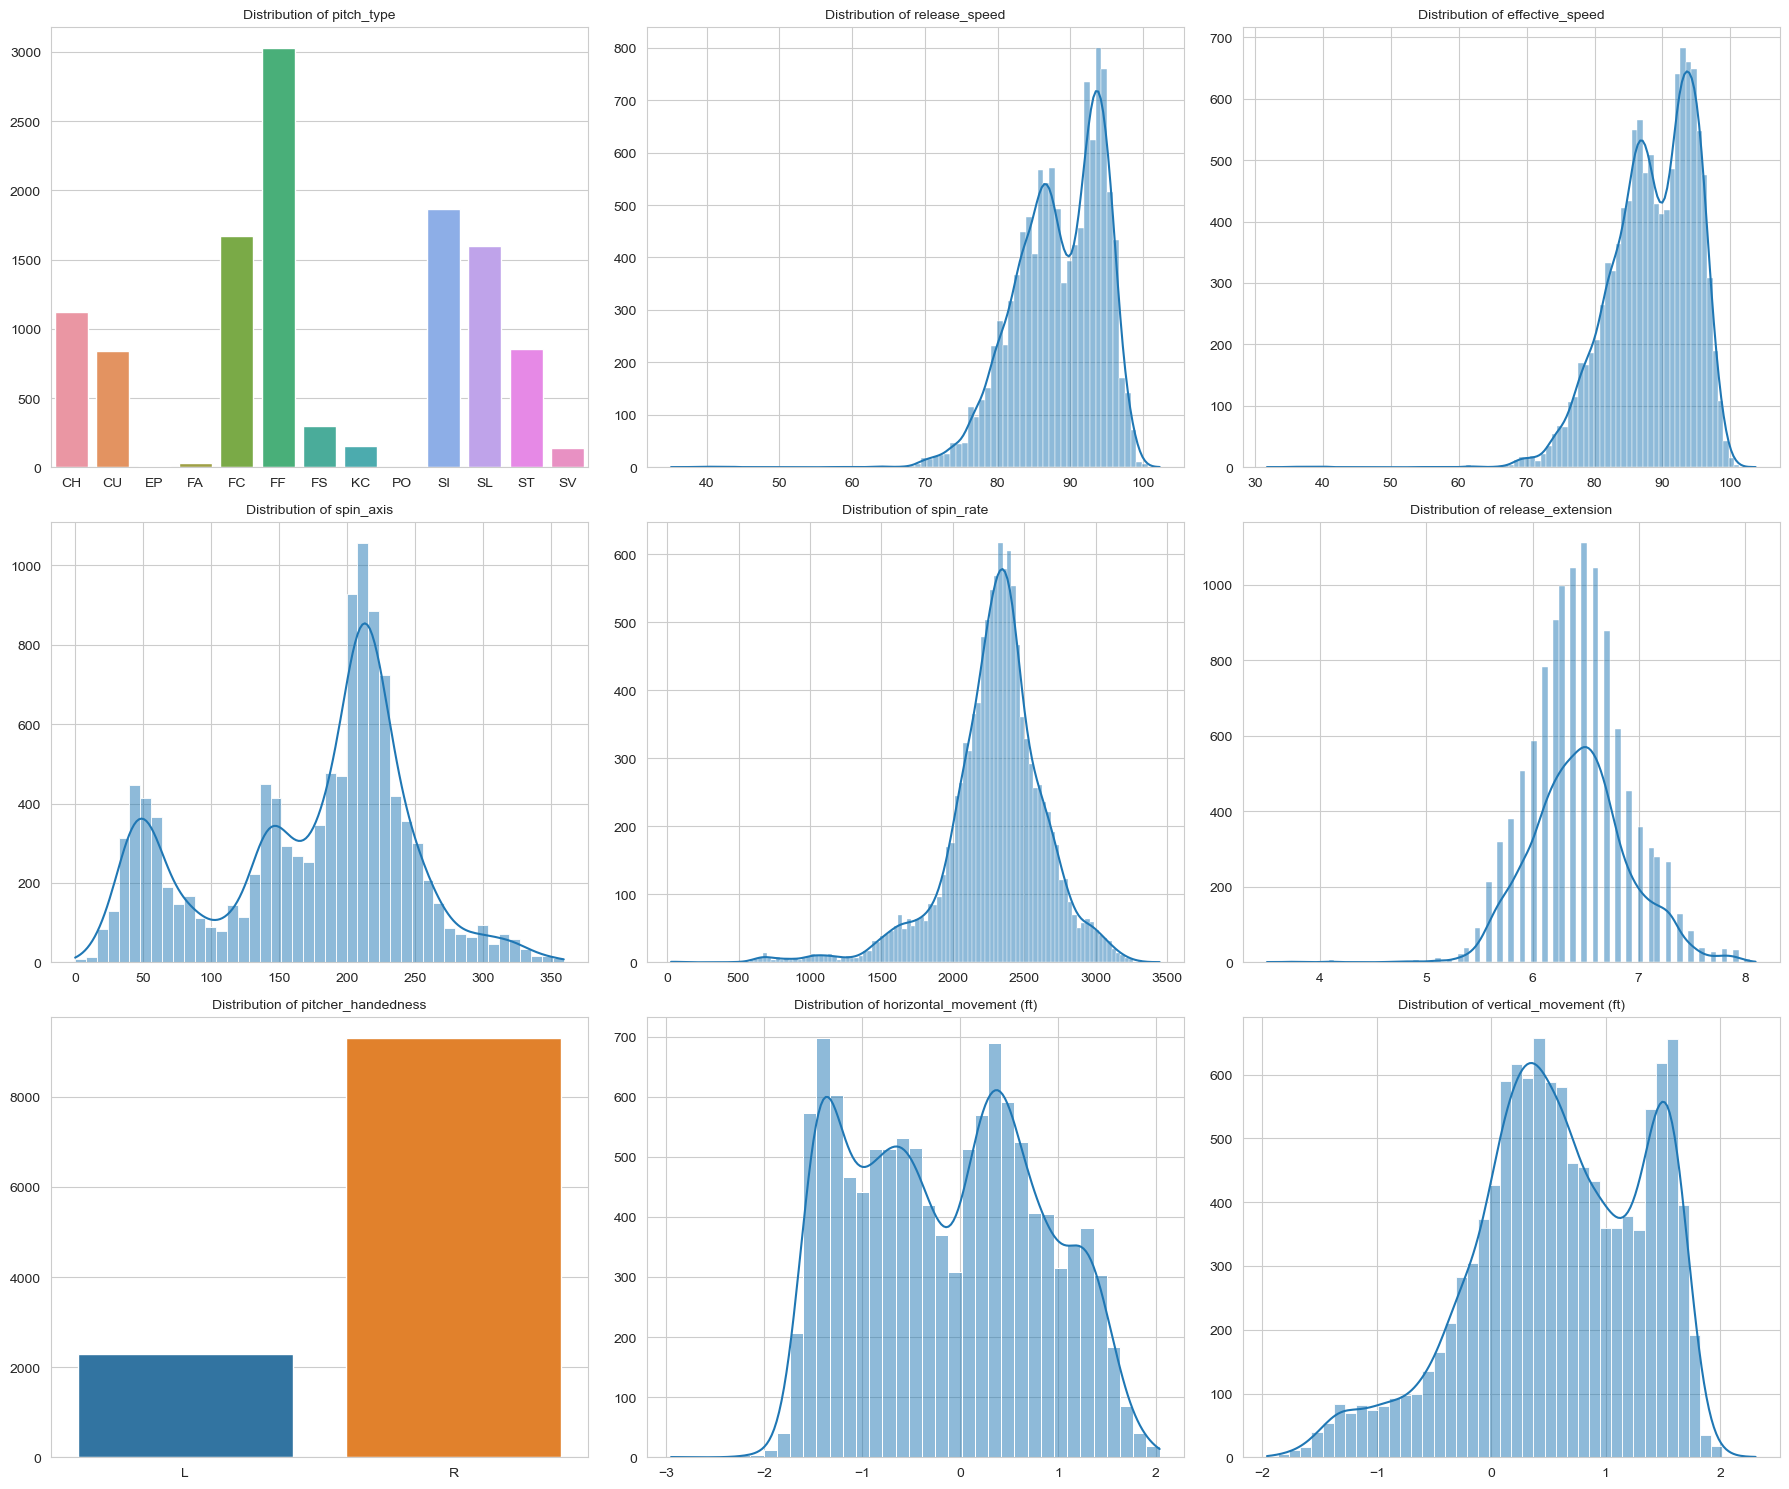

In [109]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the visualizations
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# List of all columns to plot
all_columns = ['pitch_type', 'release_speed', 'effective_speed', 'spin_axis', 'spin_rate', 'release_extension', 
               'pitcher_handedness', 'horizontal_movement (ft)', 'vertical_movement (ft)', 'description']

numeric_columns = ['release_speed', 'effective_speed', 'spin_axis', 'spin_rate', 'release_extension', 
               'horizontal_movement (ft)', 'vertical_movement (ft)']
# Plot histograms for numeric columns and count plots for categorical columns
for ax, column in zip(axes.flatten(), all_columns):
    if column in numeric_columns:  # Plot histogram for numeric columns
        sns.histplot(df_pitches_compact[column], kde=True, ax=ax)
    else:  # Plot count plot for categorical columns
        sns.countplot(data=df_pitches_compact, x=column, ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Tight layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

release_speed, effective_speed, spin_rate, and vertical_movement are all skewed right. horizontal_movement is bimodal. While release_extension is somewhere in between normal and right-skewed and spin-axis is multimodal. Right-handed pitches are far more common than left-handed. FF, SI, SL, and FC are the most common pitches while EP, FA, and PO are least common.

Plotting the count of the Target Variable

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


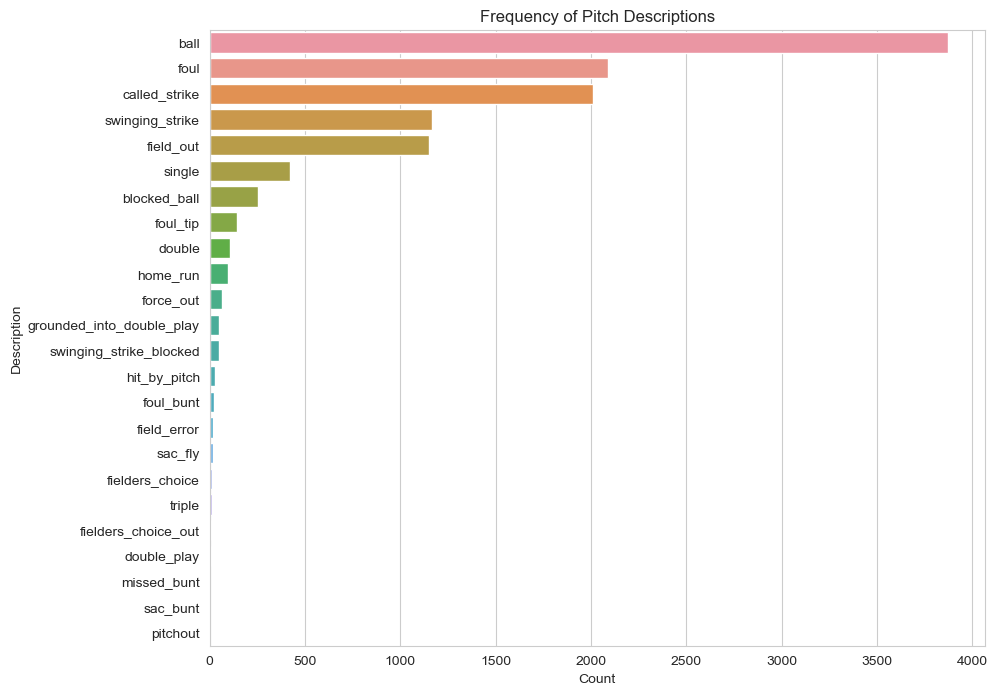

In [110]:
# Plot the count of the target variable 'description'
plt.figure(figsize=(10, 8))
sns.countplot(y='description', data=df_pitches_compact, order=df_pitches_compact['description'].value_counts().index)
plt.title('Frequency of Pitch Descriptions')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()

Plot correlation matrix

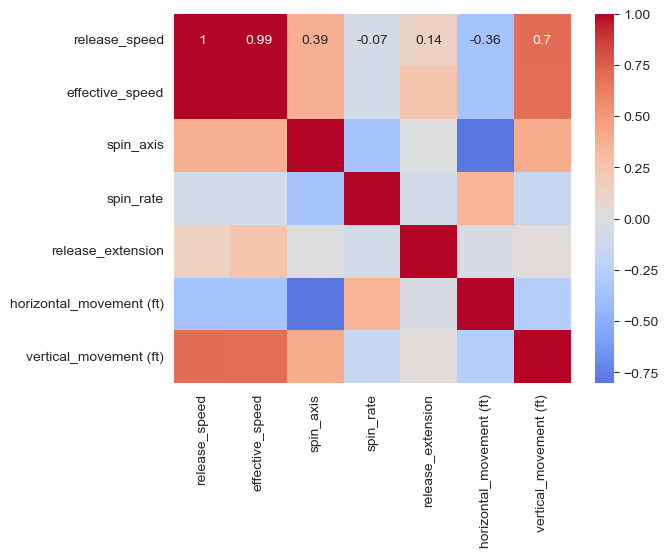

In [111]:
# Create a heatmap of the correlation matrix to visualize the relationships between all pairs of variables
sns.heatmap(df_pitches_compact.select_dtypes(include='float').corr(), annot=True, cmap='coolwarm', center=0) # create a heatmap of the correlation matrix
plt.show()

There is some correlation shown here between release/effective speed and vertical movement as well as spin axis with vertical movement and release/effective speed.

## Binning the target variable

When looking at the target variable we found that there were a large number of outcomes for the target variable; however these outcomes boiled down to four main true outcomes. There were many different types of balls that were tracked, but each of these types of balls have had the same game outcome. The same was true of strikes, which come in large large variety from called strikes to swinging strikes to foul balls. All of these outcomes have the same effect on the game so we grouped them together. Similarly, for field outs it does not matter the way in which the out is recorded the outcome is all the same, so we grouped them together. Finally, we decided to group hits together, since although they have a slightly different effect on the pitcher, they represent the same effect as the pitcher has allowed a base runner and failed to record an out, so we decided to group them together. The groupings we choose are listed below. 
Categories:

Balls: ball, blocked_ball, hit_by_pitch, pitchout

Strikes: called_strike, swinging_strike, foul, foul_tip, missed_bunt, swinging_strike_blocked, foul_bunt 

Hits: single, double, triple, home_run

Field Outs: sac_bunt, fielders_choice_out, fielders_choice, sac_fly, field_error, force_out, field_out

In [112]:
# Group hits
if 'hit' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('hit')
# Group field_out
if 'field_out' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('field_out')
# Group strike
if 'strike' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('strike')
# Group ball
if 'ball' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('ball')
for index, row in df_pitches_description.iterrows():
    if row['description'] == 'ball' or row['description'] == 'blocked_ball' or row['description'] == 'hit_by_pitch' or row['description'] == 'pitchout':
        df_pitches_description.at[index, 'description'] = 'ball'
    elif row['description'] == 'called_strike' or row['description'] == 'swinging_strike' or row['description'] == 'foul' or row['description'] == 'foul_tip' or row['description'] == 'missed_bunt' or row['description'] == 'swinging_strike_blocked' or row['description'] == 'foul_bunt':
        df_pitches_description.at[index, 'description'] = 'strike'
    elif row['description'] == 'single' or row['description'] == 'double' or row['description'] == 'triple' or row['description'] == 'home_run':
        df_pitches_description.at[index, 'description'] = 'hit'
    else:
        df_pitches_description.at[index, 'description'] = 'field_out'

# remove unnecessary empty columns
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['blocked_ball'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['called_strike'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['double'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['double_play'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['field_error'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['fielders_choice'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['fielders_choice_out'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['force_out'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul_tip'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['grounded_into_double_play'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['hit_by_pitch'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['home_run'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['missed_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['pitchout'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['sac_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['sac_fly'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['single'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['swinging_strike'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['swinging_strike_blocked'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['triple'])

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

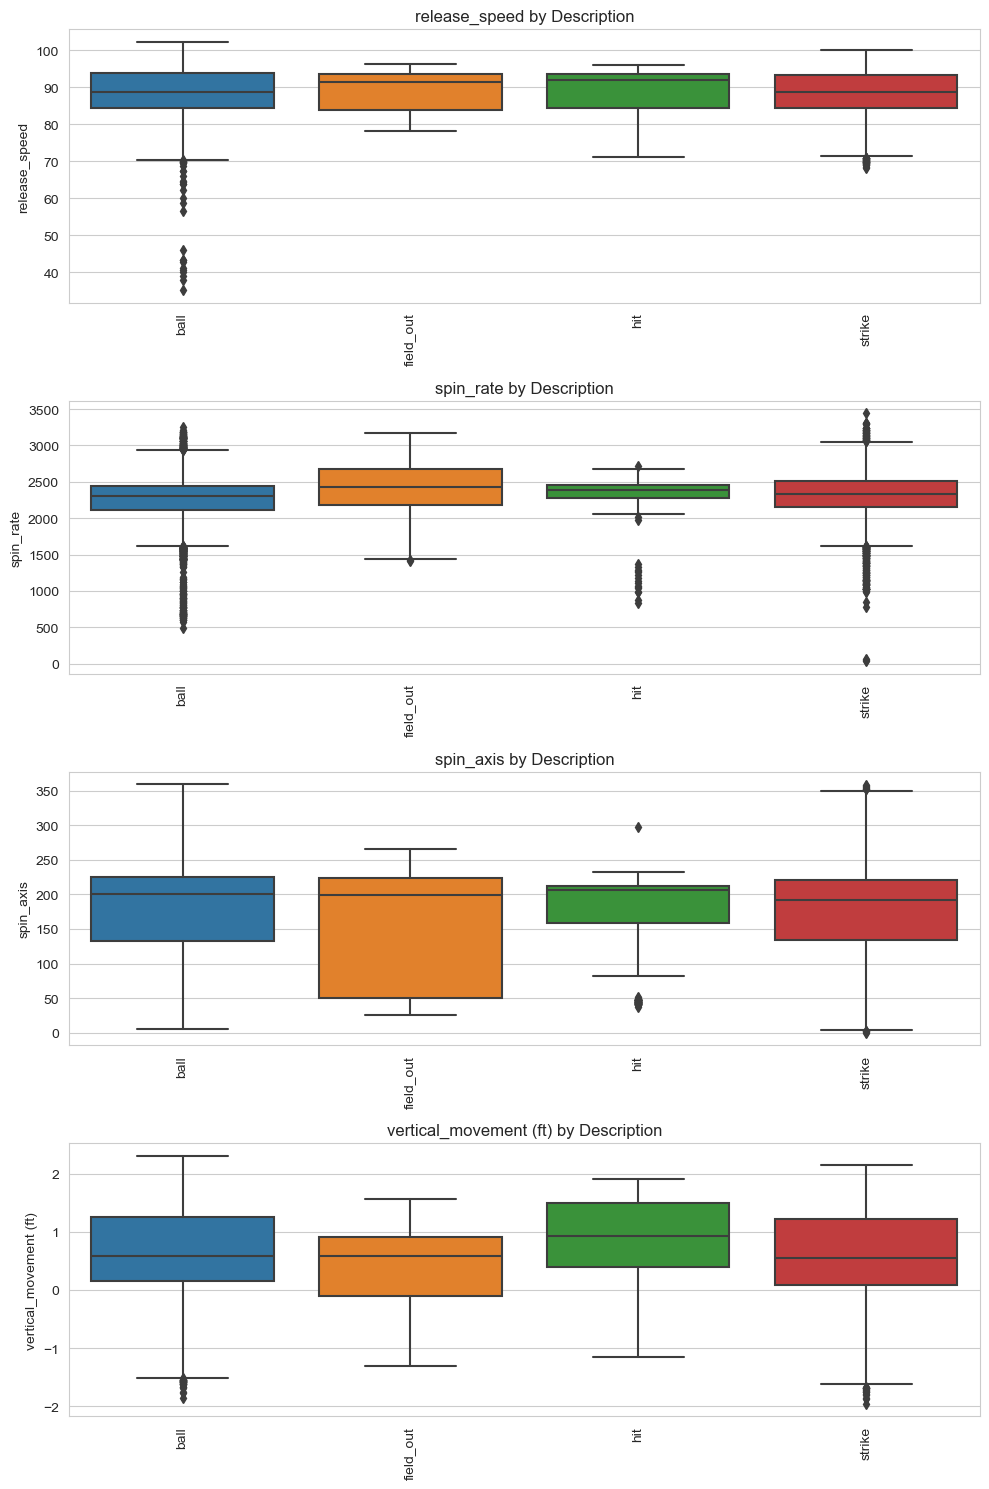

In [113]:
# Create box plots for a few selected numeric features against the target variable 'description'
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Selected features for detailed examination against the target variable
selected_features = ['release_speed', 'spin_rate', 'spin_axis', 'vertical_movement (ft)']

for ax, feature in zip(axes, selected_features):
    sns.boxplot(x='description', y=feature, data=df_pitches_description, ax=ax)
    ax.set_title(f'{feature} by Description')
    ax.set_xlabel('')
    ax.set_ylabel(f'{feature}')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


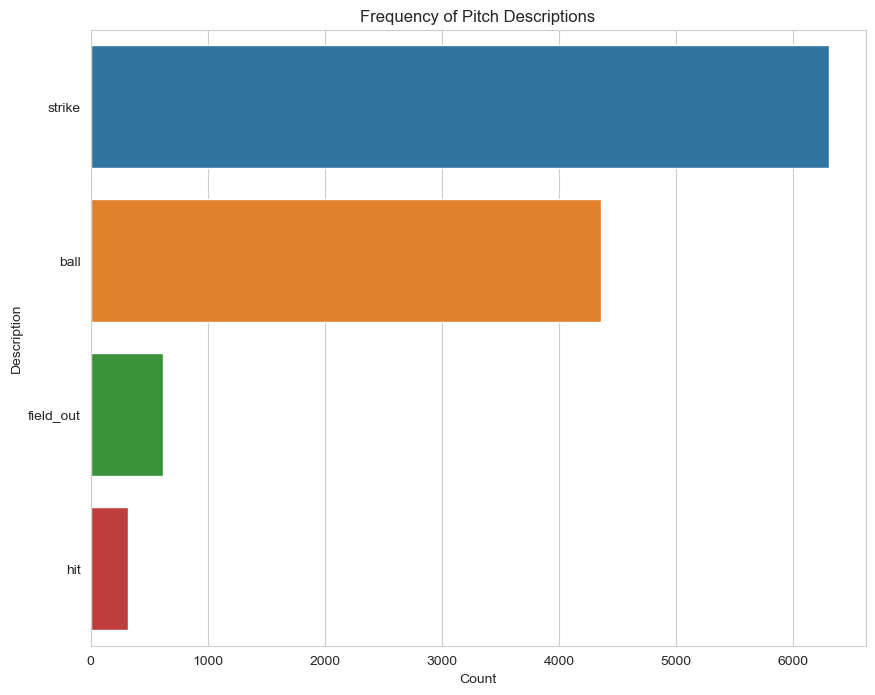

In [114]:
plt.figure(figsize=(10, 8))
sns.countplot(y='description', data=df_pitches_description, order=df_pitches_description['description'].value_counts().index)
plt.title('Frequency of Pitch Descriptions')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()

As you can see above, the most outliers are in the Ball and Strike. This makes sense because these are the most common outcomes in this dataset and they have the most data points. Hence, it is normal to see more outliers in these categories. In general, the average velocities of a pitch does not seem to have much effect on the outcomes, although pitches of higher spin rates tend to represent a larger amount of the recorded field outs. Similarly, pitches with lower spin axes tend to represent a larger portion of the field outs when compared to other outcomes. Balls and hits also tend to have more veritcal movmement on average than field_outs and strikes, although for ball and strike in every category it seems that there whisters entails the entirety of the range. 

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\20lam\anaconda3\envs\csci349\lib\site

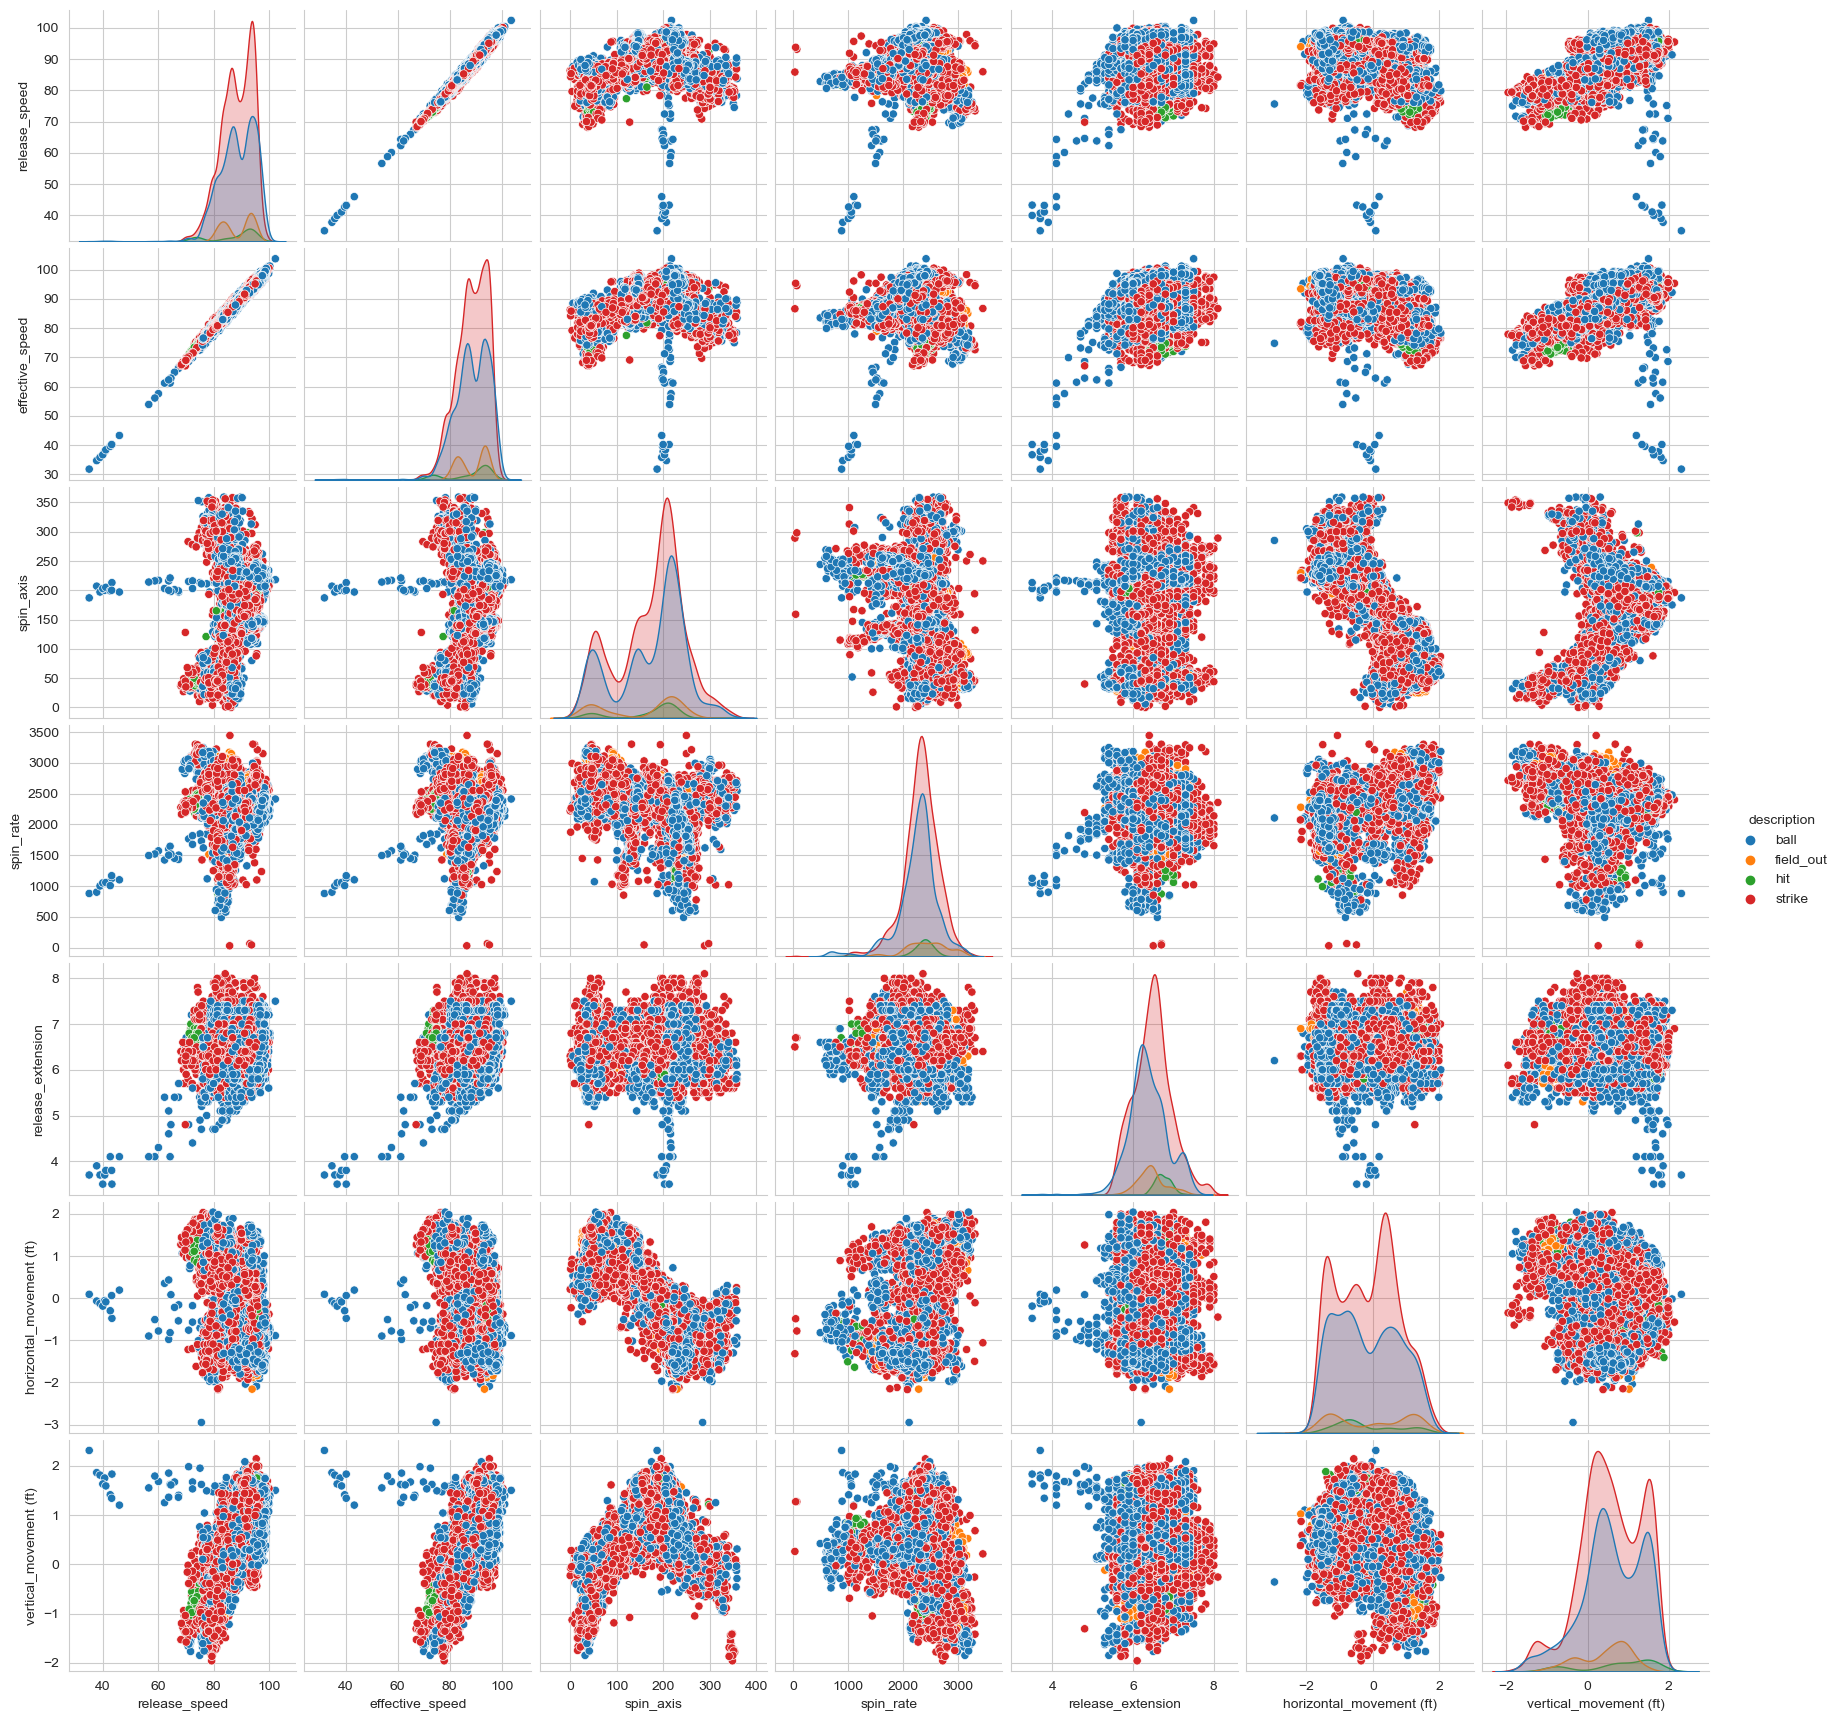

In [115]:
filtered_df2 = df_pitches_compact

# Pairplot of the filtered DataFrame
sns.pairplot(filtered_df2, hue='description')
plt.show()

We can see from the dataset that ball contains the most outliers in terms of all aspects, but that the use of the bins drastically improves the clustering of the data and allows for better analysis

### Correlating Pitch Type and Outcome

Create chi-squared test for the pitch type and description

In [116]:
from scipy.stats import chi2_contingency

# Creating a contingency table for 'pitch_type' and 'description'
contingency_table = pd.crosstab(df_pitches_description['pitch_type'], df_pitches_description['description'])

# Performing the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p, dof
print(f"Chi-squared: {chi2}")
print(f"p-value: {p}")
print(f"Degree of Freedom: {dof}")

Chi-squared: 2334.2043580792674
p-value: 0.0
Degree of Freedom: 36


In [117]:
contingency_table

description  ball  field_out  hit  strike
pitch_type                               
CH            396         37    0     686
CU            304          0   62     471
EP             10          0    0       0
FA             28          0    0       0
FC            397        103   32    1138
FF           1303         37  138    1552
FS            100          0   16     181
KC             97         41    0      18
PO              1          0    0       0
SI            736        200   39     890
SL            653         47   29     866
ST            337         49    0     468
SV              0        105    0      32

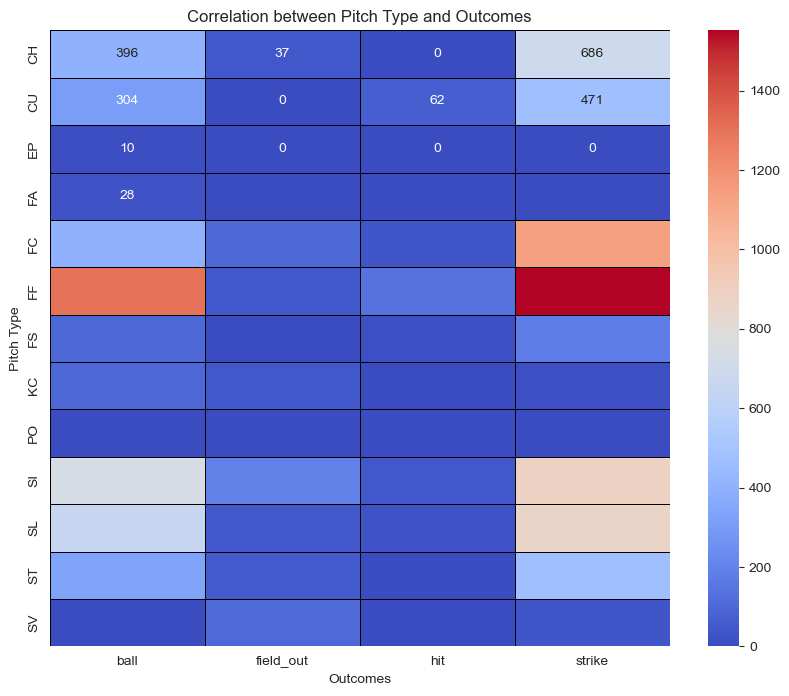

In [118]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt="d",\
     cmap="coolwarm", linewidths=0.5, linecolor='black')
plt.title('Correlation between Pitch Type and Outcomes')
plt.xlabel('Outcomes')
plt.ylabel('Pitch Type')
plt.show()

The p-value is effectively zero, which suggests that there is a statistically significant association between the type of pitch and the description of the pitch's outcome. This means that different types of pitches likely lead to different outcomes.

The pitch types are encoding as the following:
* Fastball (FF)
* Sinker (SI)
* Cutter (FC)
* Changeup (CH)
* Split-finger (FS)
* Forkball (FO)
* Screwball (SC)
* Curveball (CU)
* Knuckle curve (KC)
* Slow curve (CS)
* Slider (SL)
* Sweeper (ST)
* Slurve (SV)
* Knuckleball (KN)

As can be seen in the correlation matrix above strike is highly correlated with fastball and correlated with cutter, slider, and sinker. There is a moderate correlate with strike and changup, curveball, and sweeper. 

Ball is also correlated with fastball,  correlated with sinker, and has moderate correlations with slider, changeup, curveball, cutter, and sweeper.

There are no strong correlations between field_out and hit with any of the pitches.

---

# Modeling:

We modeled our data using both neural networks and decision trees. Grid search was used on the testing data to determine the best parameters for both models and cross validation was used to best train the data. The models classify the data based on the predictor variables such as pitch type, pitcher handedness, and pitch speed to determine the target which has 4 classes: ball, field out, hit, and strike. The neural network had stronger performance than the decision tree, so it is what we used for our final model. 

### Models Comparison
The neural network had an 86.42% accuracy on the testing data while the decision tree model had an 81.07% accuracy on the testing data.


### Hyperparameter Selection
Grid search was used to determine the best hyperparamters for both models. The best parameters for the neural network were:

batch size: 8

epochs: 200

model loss: categorical cross entropy

number of hidden nodes: 100

optimizer: adam

activation function: relu

## Data Preparation for Modeling

The data preparation for modeling is performed below. The data is split into X and y frames with X being the predictor variables and y being the target variable (the result of the pitch). The categorical columns in X and y are then binarized and the data is split with 80% going to training and 20% going to testing.

In [119]:
# Change name of dataframe to be for model
df_pitches_model = df_pitches_description
df_pitches_model['description'].unique()

['ball', 'field_out', 'strike', 'hit']
Categories (4, object): ['ball', 'field_out', 'hit', 'strike']

In [120]:
df_pitches_model.columns

Index(['pitch_type', 'release_speed', 'effective_speed', 'spin_axis',
       'spin_rate', 'release_extension', 'pitcher_handedness',
       'horizontal_movement (ft)', 'vertical_movement (ft)', 'description'],
      dtype='object')

Split data into X and y frames

In [121]:
X = df_pitches_model[['pitch_type', 'release_speed', 'effective_speed',
       'spin_axis', 'spin_rate', 'release_extension', 'pitcher_handedness',
       'horizontal_movement (ft)', 'vertical_movement (ft)']]

y = df_pitches_model['description']
X.head(10)

pitch_type  release_speed  effective_speed  spin_axis  \
player_name                                                           
Bello, Brayan         SL      86.800003        87.900002       50.0   
Bello, Brayan         CH      83.300003        84.699997      246.0   
Bello, Brayan         SI      96.000000        96.800003      247.0   
Bello, Brayan         CH      84.800003        85.599998      256.0   
Bello, Brayan         SL      85.500000        86.400002       27.0   
Bello, Brayan         SI      95.800003        97.000000      243.0   
Bello, Brayan         SL      86.800003        87.300003       56.0   
Bello, Brayan         CH      85.599998        86.400002      251.0   
Berríos, José         SI      93.699997        93.900002      223.0   
Bello, Brayan         SI      95.300003        96.400002      247.0   

               spin_rate  release_extension pitcher_handedness  \
player_name                                                      
Bello, Brayan     2437.0                6.4                  R   
Bello, Brayan     1737.0                6.8                  R   
Bello, Brayan     1992.0                6.7                  R   
Bello, Brayan     1650.0                6.7                  R   
Bello, Brayan     2366.0                6.8                  R   
Bello, Brayan     2023.0                6.7                  R   
Bello, Brayan     2298.0                6.2                  R   
Bello, Brayan     1533.0                6.5                  R   
Berríos, José     1855.0                6.6                  R   
Bello, Brayan     1919.0                6.7                  R   

               horizontal_movement (ft)  vertical_movement (ft)  
player_name                                                      
Bello, Brayan                      0.33                    0.20  
Bello, Brayan                     -1.32                    0.36  
Bello, Brayan                     -1.43                   -0.11  
Bello, Brayan                     -1.34                    0.29  
Bello, Brayan                      0.38                    0.29  
Bello, Brayan                     -1.41                    0.17  
Bello, Brayan                      0.51                    0.08  
Bello, Brayan                     -1.40                    0.00  
Berríos, José                     -1.37                    0.80  
Bello, Brayan                     -1.45                   -0.04

In [122]:
y.head(10)

player_name
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Bello, Brayan         ball
Berríos, José    field_out
Bello, Brayan         ball
Name: description, dtype: category
Categories (4, object): ['ball', 'field_out', 'hit', 'strike']

Binarize all categorical columns. In X these are pitch_type and pitcher_handedness. In y this is the entire data. The data needs to be binarized for the neural network.

In [123]:
X_binarized = pd.get_dummies(X, dtype=int)
y_binarized = pd.get_dummies(y, dtype=int)
X_binarized.sample(10)

release_speed  effective_speed  spin_axis  spin_rate  \
player_name                                                                
Rodriguez, Grayson      79.099998        80.199997       38.0     2802.0   
Akin, Keegan            93.699997        92.699997      136.0     2460.0   
Whitlock, Garrett       81.300003        82.800003       54.0     2129.0   
Rodón, Carlos           96.400002        96.099998      148.0     2488.0   
Wells, Tyler            92.099998        92.000000      203.0     2355.0   
Green, Chad             85.400002        85.400002       65.0     2269.0   
Rodón, Carlos           96.500000        96.000000      153.0     2510.0   
Stroman, Marcus         91.000000        90.599998      222.0     2332.0   
Wells, Tyler            87.400002        88.099998      150.0     2452.0   
Armstrong, Shawn        92.400002        94.500000      208.0     2425.0   

                    release_extension  horizontal_movement (ft)  \
player_name                                                       
Rodriguez, Grayson                7.3                      0.82   
Akin, Keegan                      5.9                      0.72   
Whitlock, Garrett                 7.5                      1.09   
Rodón, Carlos                     6.2                      0.75   
Wells, Tyler                      6.3                     -0.28   
Green, Chad                       6.5                      0.18   
Rodón, Carlos                     6.0                      0.33   
Stroman, Marcus                   6.1                     -0.88   
Wells, Tyler                      6.3                      0.38   
Armstrong, Shawn                  7.1                     -0.35   

                    vertical_movement (ft)  pitch_type_CH  pitch_type_CU  \
player_name                                                                
Rodriguez, Grayson                   -1.05              0              1   
Akin, Keegan                          1.65              0              0   
Whitlock, Garrett                     0.25              0              0   
Rodón, Carlos                         1.46              0              0   
Wells, Tyler                          1.64              0              0   
Green, Chad                           0.02              0              0   
Rodón, Carlos                         1.44              0              0   
Stroman, Marcus                       0.73              0              0   
Wells, Tyler                          0.59              0              0   
Armstrong, Shawn                      1.18              0              0   

                    pitch_type_EP  ...  pitch_type_FF  pitch_type_FS  \
player_name                        ...                                 
Rodriguez, Grayson              0  ...              0              0   
Akin, Keegan                    0  ...              1              0   
Whitlock, Garrett               0  ...              0              0   
Rodón, Carlos                   0  ...              1              0   
Wells, Tyler                    0  ...              1              0   
Green, Chad                     0  ...              0              0   
Rodón, Carlos                   0  ...              1              0   
Stroman, Marcus                 0  ...              0              0   
Wells, Tyler                    0  ...              0              0   
Armstrong, Shawn                0  ...              1              0   

                    pitch_type_KC  pitch_type_PO  pitch_type_SI  \
player_name                                                       
Rodriguez, Grayson              0              0              0   
Akin, Keegan                    0              0              0   
Whitlock, Garrett               0              0              0   
Rodón, Carlos                   0              0              0   
Wells, Tyler                    0              0              0   
Green, Chad                     0              0       

In [124]:
y_binarized.sample(10)

ball  field_out  hit  strike
player_name                                  
Civale, Aaron       1          0    0       0
Irvin, Cole         1          0    0       0
Houck, Tanner       0          0    0       1
Hamilton, Ian       1          0    0       0
Weissert, Greg      0          0    0       1
Kremer, Dean        1          0    0       0
Stroman, Marcus     0          0    0       1
Green, Chad         0          0    0       1
Pivetta, Nick       0          0    0       1
Parsons, Wes        0          0    0       1

Split data into training and test sets

In [125]:
train_X, test_X, train_y, test_y = train_test_split(X_binarized, y_binarized, test_size=0.2, random_state=42)

Standardize data

In [126]:
std = StandardScaler()
train_X_standardized = pd.DataFrame(std.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
test_X_standardized = pd.DataFrame(std.transform(test_X), columns=test_X.columns, index=test_X.index)


## Neural Networks Model
The model is trained and fit here to predict for the data set

Create a function that creates a Keras neural network model. The function requires parameters for the number of hidden nodes in the middle layer, the activation function in the middle layer (relu by default), the optimizer (adam by default), loss (categorical cross entropy by default), and the evaluation metrics (accuracy by default).

In [127]:
# Define a function that creates a Keras model
def create_keras_model(num_hidden, activation='relu', optimizer='adam', loss='categorical_crossentropy', metrics='accuracy'):

    inputs = Input(shape=train_X_standardized.shape[1]) # input layer
    
    # our hidden layer is parameterized
    layer = Dense(num_hidden, activation=activation)(inputs)
    
    outputs = Dense(test_y.shape[1],activation="softmax")(layer) # output layer
    
    model = Model(inputs=inputs, outputs=outputs, name="model_2") # build the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # compile the model

    return model

The model with various combinations of the following parameters:
* optimizer: adam, SGD
* number of hidden nodes: 10, 20, 100
* activation function: relu, tanh
* epochs: 100, 200
* batch size: 8, 16
* loss function: categorical cross entropy, sparse categorical cross entropy

The hyperparameter tuning was done using the training data which is 80% of the dataset.

The following parameters performed best and were thus selected for the model:
* batch size: 8
* epochs: 200
* model loss: categorical cross entropy
* number of hidden nodes: 100
* optimizer: adam
* activation function: relu

In [128]:
# hardcode in best parameters
# Define the best parameters
best_params_compile = {
    'num_hidden': 100,
    'optimizer': 'adam',
    'loss': 'categorical_crossentropy',
    'metrics': 'accuracy'
}

best_params_fit = {
    'batch_size': 8,
    'epochs': 200
}


Create and fit the model with the best parameters

In [129]:
# Create the model with the best parameters
best_model = create_keras_model(**best_params_compile)


In [130]:
# Fit the model with the best parameters
history = best_model.fit(train_X_standardized, train_y,\
                        verbose=1,\
                        validation_data=(test_X_standardized, test_y),\
                        batch_size=best_params_fit['batch_size'],
                        epochs=best_params_fit['epochs'])


Epoch 1/200
1160/1160 [==============================] - 2s 2ms/step - loss: 0.8379 - accuracy: 0.5980 - val_loss: 0.7747 - val_accuracy: 0.6237
Epoch 2/200
1160/1160 [==============================] - 1s 1ms/step - loss: 0.7326 - accuracy: 0.6551 - val_loss: 0.7183 - val_accuracy: 0.6668
Epoch 3/200
1160/1160 [==============================] - 2s 1ms/step - loss: 0.6762 - accuracy: 0.6899 - val_loss: 0.6843 - val_accuracy: 0.6845
Epoch 4/200
1160/1160 [==============================] - 1s 1ms/step - loss: 0.6332 - accuracy: 0.7104 - val_loss: 0.6354 - val_accuracy: 0.7138
Epoch 5/200
1160/1160 [==============================] - 1s 1ms/step - loss: 0.6005 - accuracy: 0.7328 - val_loss: 0.6108 - val_accuracy: 0.7349
Epoch 6/200
1160/1160 [==============================] - 1s 1ms/step - loss: 0.5743 - accuracy: 0.7480 - val_loss: 0.5849 - val_accuracy: 0.7496
Epoch 7/200
1160/1160 [==============================] - 1s 1ms/step - loss: 0.5544 - accuracy: 0.7564 - val_loss: 0.5867 - val_ac

1160/1160 [==============================] - 2s 2ms/step - loss: 0.4324 - accuracy: 0.8122 - val_loss: 0.4727 - val_accuracy: 0.8082
Epoch 19/200
1160/1160 [==============================] - 2s 1ms/step - loss: 0.4259 - accuracy: 0.8131 - val_loss: 0.4769 - val_accuracy: 0.8026
Epoch 20/200
1160/1160 [==============================] - 2s 2ms/step - loss: 0.4184 - accuracy: 0.8191 - val_loss: 0.4873 - val_accuracy: 0.7823
Epoch 21/200
1160/1160 [==============================] - 2s 2ms/step - loss: 0.4128 - accuracy: 0.8210 - val_loss: 0.4789 - val_accuracy: 0.7935
Epoch 22/200
1160/1160 [==============================] - 2s 1ms/step - loss: 0.4108 - accuracy: 0.8282 - val_loss: 0.4594 - val_accuracy: 0.8082
Epoch 23/200
1160/1160 [==============================] - 2s 2ms/step - loss: 0.4054 - accuracy: 0.8305 - val_loss: 0.4438 - val_accuracy: 0.8233
Epoch 24/200
1160/1160 [==============================] - 2s 2ms/step - loss: 0.3992 - accuracy: 0.8296 - val_loss: 0.4374 - val_accuracy

----

# Performance Results:

This section provides performance results of the model with classification reports to show the performance of each class, precision/recall curves, and confusion matrices. 

Plot the loss and accuracy of the model for both testing and training data using the best model.

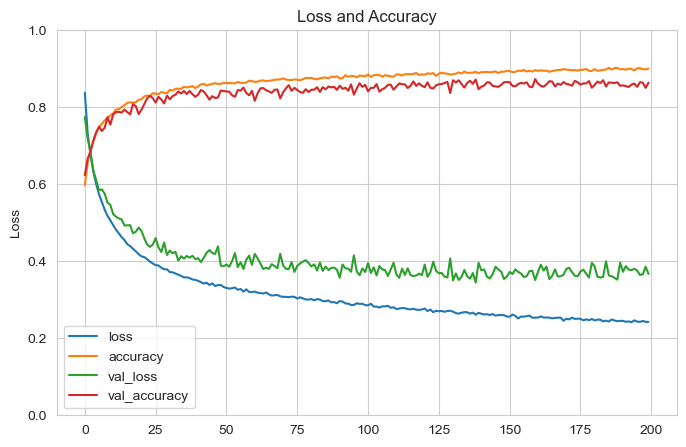

In [131]:
pd.DataFrame(history.history).plot( figsize=(8, 5),grid=True, ylim=(0,1),ylabel="Loss")
plt.title('Loss and Accuracy')
plt.show()

Overall, the model has a strong accuracy that continues to increase >80% over the epochs for both the training and testing data while the loss continues to decrease

When evaluating how the model performs on each of the target classes it is important to consider in the context of baseball. The precision tells how many of the predicted positive cases were actually positive. While recall tells how many of the actual positive cases were predicted correctly. 

Create label mapping to use for results

In [132]:
# Mapping dictionary for numerical class labels to species names
label_map = {0: 'ball', 1: 'field_out', 2: 'hit', 3: 'strike'}

Predict the training data and print the classification report.

In [133]:
# make training data y into same format as predicted
train_y_class = np.argmax(train_y, axis=1)
# predict results on training data
train_pred_y_prob = best_model.predict(train_X_standardized)
# convert to single values
train_pred_y = np.argmax(train_pred_y_prob, axis=1)
# convert numbers to target class names for training and predicted data
y_train_class = [label_map[label] for label in train_y_class]
y_pred_class = [label_map[label] for label in train_pred_y]
print("Classification Report (TRAINING DATA)\n")
print(classification_report(y_train_class, y_pred_class))


290/290 [==============================] - 0s 926us/step
Classification Report (TRAINING DATA)

              precision    recall  f1-score   support

        ball       0.89      0.91      0.90      3486
   field_out       0.87      0.91      0.89       492
         hit       0.81      0.77      0.79       253
      strike       0.93      0.92      0.92      5048

    accuracy                           0.91      9279
   macro avg       0.88      0.88      0.88      9279
weighted avg       0.91      0.91      0.91      9279



The model performs well in distinguishing between balls, field outs, and strikes with high precision and recall scores for these classes, however, it struggles more with the hit class, as indicated by lower recall and F1 scores. 

Predict the testing data and print the classification report and confusion matrix

73/73 [==============================] - 0s 1ms/step
Classification Report (TESTING DATA)

              precision    recall  f1-score   support

        ball       0.85      0.87      0.86       876
   field_out       0.84      0.82      0.83       127
         hit       0.67      0.49      0.57        63
      strike       0.89      0.88      0.88      1254

    accuracy                           0.86      2320
   macro avg       0.81      0.77      0.78      2320
weighted avg       0.86      0.86      0.86      2320


Confusion Matrix (TESTING DATA)



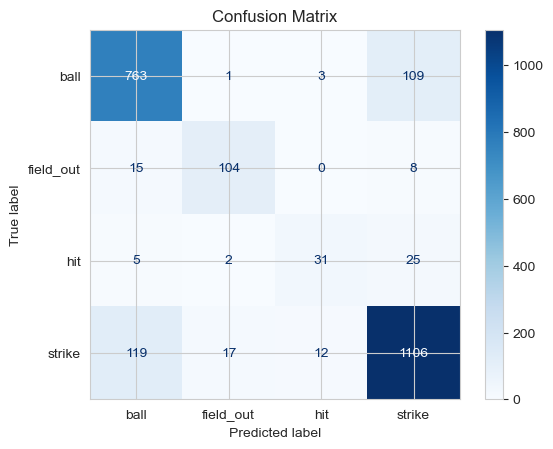

In [134]:
# make testing data y into same format as predicted
test_y_class = np.argmax(test_y, axis=1)
# predict results on testing data
test_pred_y_prob = best_model.predict(test_X_standardized)
# convert to single values
test_pred_y = np.argmax(test_pred_y_prob, axis=1)
# convert numbers to target class names for testing and predicted data
y_test_class = [label_map[label] for label in test_y_class]
y_pred_test_class = [label_map[label] for label in test_pred_y]
print("Classification Report (TESTING DATA)\n")
print(classification_report(y_test_class, y_pred_test_class))
# display confusion matrix
print("\nConfusion Matrix (TESTING DATA)\n")
cm = confusion_matrix(y_test_class, y_pred_test_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['ball', 'field_out', 'hit', 'strike'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The model performs well overall with high precision and recall for "ball," "field_out," and "strike" classes. However, it struggles with the "hit" class, showing lower precision, recall, and F1-score, indicating that it has difficulty correctly identifying hits. This indicates that the model may be falsely predicting hits as other results, which is important to consider when using the results to determine the best pitch.

The confusion matrix shows the model predictions on the testing data by class. The model rarely mispredicts field out but sometimes mispredicts strike as a ball and ball as a strike.

### Plot ROC curves

Create ROC curve for training data

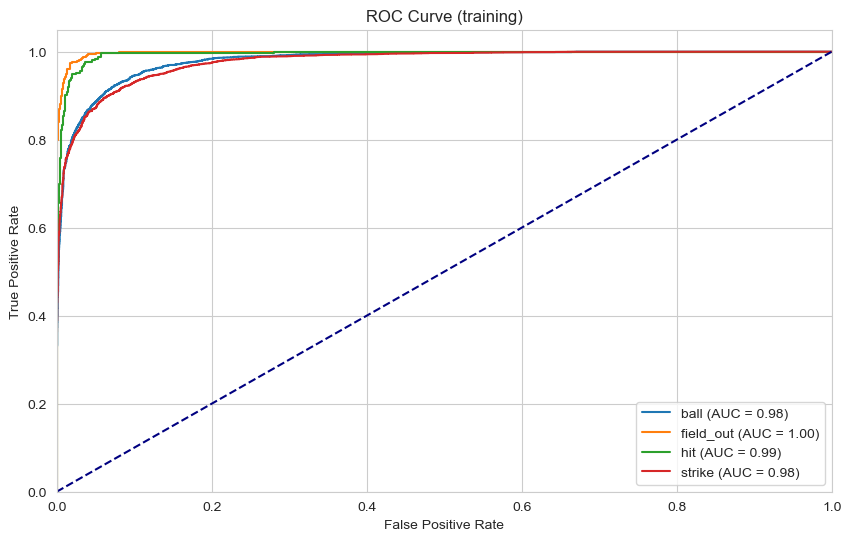

In [161]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_map)):
    fpr[i], tpr[i], _ = roc_curve(train_y_class == i, train_pred_y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(len(label_map)):
    plt.plot(fpr[i], tpr[i], label=f'{label_map[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (training)')
plt.legend(loc="lower right")
plt.show()

Create ROC curve for testing data

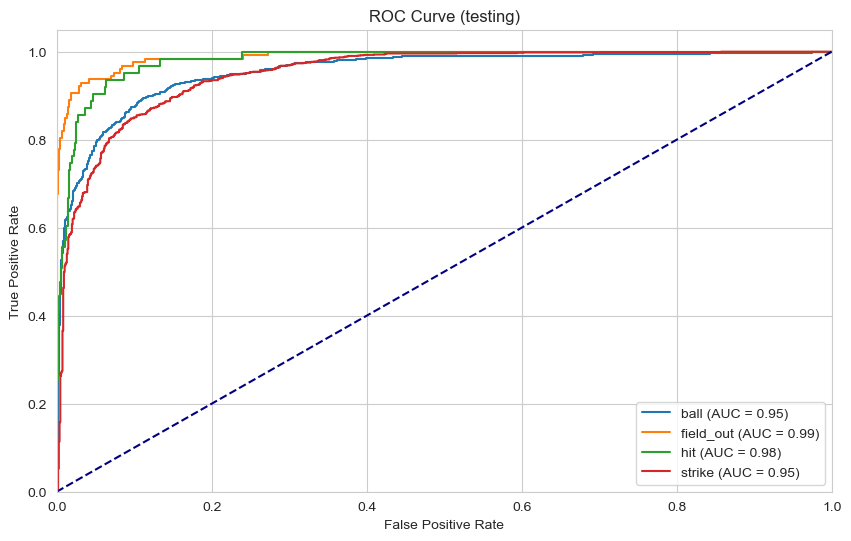

In [162]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_map)):
    fpr[i], tpr[i], _ = roc_curve(test_y_class == i, test_pred_y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(len(label_map)):
    plt.plot(fpr[i], tpr[i], label=f'{label_map[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (testing)')
plt.legend(loc="lower right")
plt.show()

Plot the Precision-Recall curve for each class in the testing data.

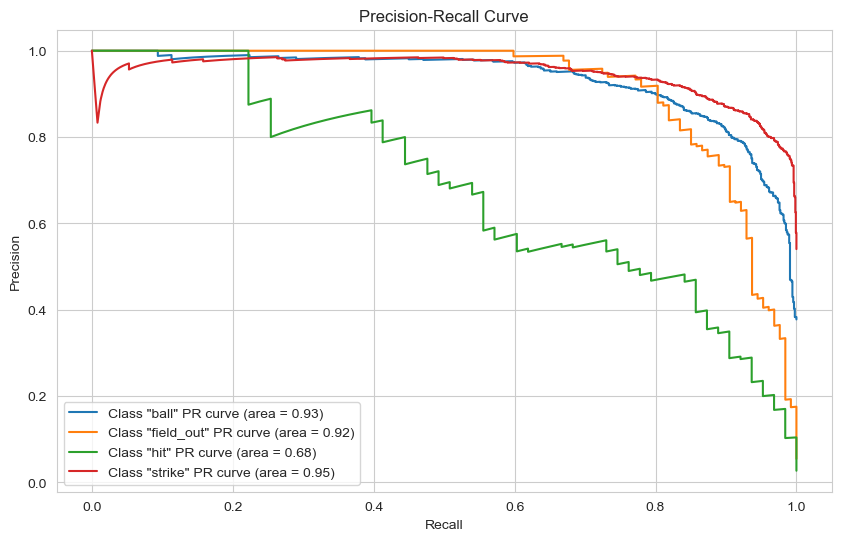

In [170]:
# Compute precision-recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(label_map)):
    precision[i], recall[i], _ = precision_recall_curve(test_y_class == i, test_pred_y_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 6))
for i in range(len(label_map)):
    plt.plot(recall[i], precision[i],label=f'Class "{label_map[i]}" PR curve (area = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In general, when looking at the precision and recall curves for the neural network, the model was farily accurate in terms of both having a high degree of precision and recall in 3 of the four categories with only hits being the most difficult to predict with both outcomes. This is to be expected considering hits are the most uncommon outcome in a baseball game and therefore do not have as much data to go on in order to make a proper determination. A simple method to resolve this issue would be to provide much more data containing hits in order to give the system more data to review. The ROC curves had no real issues, all of the data appeared to be similar in that none had an large false positive rate or a low true positive rate. Balls and strike has slight worse accuracy since they represented a larger portion of the dataset and may have been selected more often as a result of covering a wider array of pitch inputs. An increase in the size of the data would almost certainly improve these metrics. For the decision tree the ROC and precision recall curves were both significantly worse than that of the neural network. There was a significant dropoff in the recall as the precision increase across all of the data to a high degree. The best decision tree metrics underperformed the worst neural net metrics in terms of area, .605 to .8. In general, hit was still the lowest performing metric because of the minimal amount of training data that contained hit as an outcome, but even the larger data sets still underperformed. 

# Discussion:

We did not have many challenges when cleaning the data. For the most part, the guide given to us when reading through the data helped us to understand exactly what we were looking at, combined with our own existing knowledge on how the data is tracked and inputed by the MLB and what it means in terms of a game in general. It was easy to understand what data had no importance on the effectiveness of a given pitch and could be eliminated, espeically after performing visualization to confirm it as such. We did have an issue in limiting the parameters down into bins in order to make them easier to test. Many of hte possible outcomes of a pitch are marked differently, yet have the same overall outcome, so we used our existing knowledge to group them into the four true outcomes of a pitch. After we completed that tested and modeling was much more smooth and our results were much more consistent and easier to understand. Overall, when modeling we were not extremely surprised by the results. Bining the data allowed for much more effective modeling and the neural networks performed much better overall than the decision tree in terms of percentage loss and on ROC curves. (Talk about hyoerparameters used here). In general, we found that higher extension, velocity, vertical movement, and spin axes pitches tended to yield more strikes, but also more hits as a result of their limited movement. This is not very surprising since these attributes are common in fastballs which tend to be the easiest pitches to control for a pitcher and thereby would be expected to land in the strike zone more often, but also be hit more. Conversely, pitches of lower vertical movement, velocity, spin axes, extension, and higher spin tended to land more often for balls, but also generate more field outs. These attributes are associated with breaking pitches and changeups which are much harder to controls becasue of the high degrees of movements making them ahrder to throw in the strike zone, but also much more difficult to hit. Horizontal movement and pitcher handedness really did not have much effect on the outcome of an at bat. The model was extremely effective at determining the outcomes of pitches, with the best accuracy being around 86%, which is rather high when taking into account the fact that there are four possible outcomes so the expected accuracy based on random chance would be around 25%. The accuracy tended to be lower at first on field_outs and hits because of the smaller amounts of data for those categories as they typically happen less often however, as the training continued their accuracy grew to around 80% as well in later models meaning they could predict even smaller probability events with significantly higher accruracy. This all points to the fact that there exists a correlation between the metrics of a pitch and its type and its outcome in the game, especially considering the fact that the model was predicted a large amount of outcomes. 

# Conclusion:

As stated previously, we found that fastball tended to yield a higher degree of success as a strike, but if strike by the batter it had a higher likelyhood of becoming a hit tham breaking pitches. Both models seemed to hint at this as they were quite accurate in predicting the outcomes of a pitch given its attributes. The model did struggle at time to predict when a pitch was a ball or a strike as these categories had a high degree of variance in they're data sets, but in terms of predicting hits and field outs they were extremely effective. For future reference, it would make sense to add more data, especially of hits and field outs as those categories were dwarfed by the amount of strike and ball data, but the models both performed quite well and given the high degree of accuracy (approximately 86.7%), we can assume that there is a significant relation between a pitch and its attriubutes and its outcome in the game.

In this final part we will use the model to show real-life utilization of this data. Pitchers have a certain set of pitches that are able to throw. We will take the 3 pitchers with the most data in the set and sort their data by pitch type. We then take the average of each of the metrics for each of the pitchers for each of their pitch type. For example, Pitcher 1's average metrics for his fast ball. We then use these results in the model to determine the most likely result of each of the pitchers' pitches. 

Create function that outputs average stats for pitcher by type

In [246]:
def averages_for_pitcher(player_name):
    print(f"PLAYER: {player_name}\n")
    # Filter training data for the specific pitcher
    data_for_pitcher = df_pitches_model.loc[df_pitches_model.index == player_name]

    # Sort the combined data by pitch type
    all_data_for_pitcher_X_sorted = data_for_pitcher.sort_values(by='pitch_type')
    # Reset index to make 'pitch_type' a column
    all_data_for_pitcher_X_sorted.reset_index(inplace=True)
    # Extract numerical columns
    numerical_columns = ['release_speed', 'effective_speed', 'spin_axis', 'spin_rate', 'release_extension', 
                        'horizontal_movement (ft)', 'vertical_movement (ft)']

    # Extract features and target
    player_X = all_data_for_pitcher_X_sorted[numerical_columns + ['pitch_type', 'pitcher_handedness']]
    player_y = all_data_for_pitcher_X_sorted['description']

    # Print the handedness of the pitcher
    pitcher_handedness = player_X['pitcher_handedness'].iloc[0]
    print(f"PITCHER HANDEDNESS: {pitcher_handedness}\n")

    # Calculate the average of numerical columns for each pitch type
    average_values_by_pitch_type = player_X.groupby('pitch_type')[numerical_columns].mean()
    # Drop rows where any value in the numerical columns is NaN
    average_values_by_pitch_type = average_values_by_pitch_type.dropna()
    # Print out the averages for each pitch type
    print("\nAverage numerical values by pitch type:")
    print(average_values_by_pitch_type)
    
    average_values_by_pitch_type.reset_index(inplace=True)
    
    # Combine average numerical values with pitcher handedness
    data_to_predict = pd.concat([average_values_by_pitch_type,\
        pd.DataFrame({'pitcher_handedness': [pitcher_handedness] * len(average_values_by_pitch_type)})], axis=1)
    pitch_type_column = data_to_predict['pitch_type']
    return data_to_predict, pitch_type_column

Create function that uses pitcher averages and outputs results based on model

In [253]:
def predict_pitcher_results(pitcher_data, pitch_type_column):
    pitch_type_mapping = {
    'FF': 'Fastball',
    'SI': 'Sinker',
    'FC': 'Cutter',
    'CH': 'Changeup',
    'FS': 'Split-finger',
    'FO': 'Forkball',
    'SC': 'Screwball',
    'CU': 'Curveball',
    'KC': 'Knuckle curve',
    'CS': 'Slow curve',
    'SL': 'Slider',
    'ST': 'Sweeper',
    'SV': 'Slurve',
    'KN': 'Knuckleball'
}


    # Preprocess the data
    X_binarized = pd.get_dummies(pitcher_data, dtype=int)
    X_binarized = X_binarized.reindex(columns=train_X.columns, fill_value=0)  # Reindex to match train_X columns
    X_standardized = pd.DataFrame(std.fit_transform(X_binarized), columns=X_binarized.columns, index=X_binarized.index)
    # Predict results
    pred_y_prob = best_model.predict(X_standardized)
    pred_y = np.argmax(pred_y_prob, axis=1)
    pred_class = [label_map[label] for label in pred_y]
    print("Predicted Results for Pitches:")
    for pitch, result in zip(pitch_type_column, pred_class):
        print(f'Pitch: {pitch_type_mapping[pitch]}, Result: {result}\n')

Get the 3 most frequent pitchers in the data to analyze their stats

In [224]:
# Assuming pitcher_name is the index
top_pitchers = df_pitches_model.index.value_counts().nlargest(3)

# Print the three most frequent pitchers
print("Top three most frequent pitchers:")
print(top_pitchers)

Top three most frequent pitchers:
player_name
Burnes, Corbin    369
Bello, Brayan     364
Cortes, Nestor    360
Name: count, dtype: int64


Get all data for Corbin Burnes and print his averages for the types of pitches he throws

In [249]:
player_name = 'Burnes, Corbin'
pitcher_data, pitch_type = averages_for_pitcher(player_name)

PLAYER: Burnes, Corbin

PITCHER HANDEDNESS: R


Average numerical values by pitch type:
            release_speed  effective_speed   spin_axis    spin_rate  \
pitch_type                                                            
CH              88.103844        88.519234  212.538467  2112.038574   
CU              80.095871        80.235046   48.309277  2890.577393   
FC              94.899445        95.605003  183.966660  2752.594482   
SI              96.086960        96.578262  195.217392  2434.652100   
SL              86.730232        87.197678   91.790695  2900.186035   

            release_extension  horizontal_movement (ft)  \
pitch_type                                                
CH                   6.688461                 -1.230000   
CU                   6.580412                  0.849175   
FC                   6.613889                  0.237167   
SI                   6.600000                 -1.018261   
SL                   6.604651                  0.694419   



C:\Users\20lam\AppData\Local\Temp\ipykernel_9940\4137035191.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_values_by_pitch_type = player_X.groupby('pitch_type')[numerical_columns].mean()


Here we are able to predict that for Corbin Burnes, his most likely results for his 5 types of pitches

In [254]:
predict_pitcher_results(pitcher_data, pitch_type)

1/1 [==============================] - 0s 20ms/step
Predicted Results for Pitches:
Pitch: Changeup, Result: ball

Pitch: Curveball, Result: ball

Pitch: Cutter, Result: strike

Pitch: Sinker, Result: strike

Pitch: Slider, Result: strike

